## Template Matching

<p style='direction:rtl; text-align: right'>
برای مچ کردن تمپلیت، از Zero Mean Cross-Correlation برای انطباق پچ و تصویر در سایز های مختلف استفاده میکنیم.
سپس در هر سایز به دنبال قسمت‌هایی از حاصل میگردیم که ریسپانس با میانگین حداقل 3sigma فاصله داشته باشد.
</p>
<p style='direction:rtl; text-align: right'>
در نهایت نقاط به دست آمده در مرحله قبل را بر حسب فاصله cluster میکنیم و از هر بخش، بهترین مچ را انتخاب کرده و نمایش می‌دهیم.
</p>

<p style='direction:rtl; text-align: right'>
ابتدا ایمپورت‌های لازم را انجام میدهیم و عکس‌‌ها را لود میکنیم.
</p>


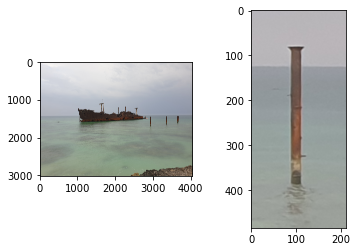

In [1]:
import cv2 as cv
import numpy as np
from scipy import signal
from sklearn import cluster
from matplotlib import pyplot as plt
%matplotlib inline

ship = cv.imread('./data/Greek_ship.jpg')
patch = cv.imread('./data/patch.png')

fig, axs = plt.subplots(1, 2)

axs[0].imshow(cv.cvtColor(ship, cv.COLOR_BGR2RGB))
axs[1].imshow(cv.cvtColor(patch, cv.COLOR_BGR2RGB))
plt.show()

<p style='direction:rtl; text-align: right'>
تابع زیر، یک پیاده سازی از ZNCC با استفاده از تبدیل فوریه است. در این تابع برای محاسبه، ZNCC را به صورت زیر در می‌آوریم که در اینجا g تمپلیت و f تصویر است:
</p>

فرض کنید

$$\tilde g_{k,l} = g_{k,l}-\bar g \implies \sum \tilde g_{k,l} = 0 $$

$$\bar f_{m,n} = \frac{1}{mn} \sum_{k,l} f_{m+k,n+l}$$

حال رابطه به شکل زیر در می‌آید

$$h_{m,n} = \frac{\sum_{k,l}{\tilde g_{k,l} \cdot (f_{m+k,n+l}-\bar f_{m,n})}}{\big(\sum_{k,l}{\tilde g_{k,l}^2}\ \sum_{k,l}{(f_{m+k,n+l}-\bar f_{m,n})^2}\big)^{1/2}}$$

  رابطه را ساده می‌کنیم

$$\sum_{k,l}{\tilde g \cdot (f_{m+k,n+l}-\bar f_{m,n})} = \sum_{k,l}{\tilde g_{k,l} \cdot f_{m+k,n+l}-\bar f_{m,n}\sum_{k,l}{\tilde g_{k,l} }} \\ =\sum_{k,l}{\tilde g_{k,l} \cdot f_{m+k,n+l}} \\ = \big[ CC(\tilde g,f)\big]_{m,n}$$

$$ \sum_{k,l}{\tilde g_{k,l}^2}  = constant = \gamma $$

$$ \sum_{k,l}{(f_{m+k,n+l}-\bar f_{m,n})^2} = \sum_{k,l}{f_{m+k,n+l}^2} + \sum_{k,l}{\bar f_{m,n}^2} + \sum_{k,l}{2f_{m+k,n+l}\bar f_{m,n}} $$

$$\sum_{k,l}{f_{m+k,n+l}^2} = \big [CC(f^2,ones(k,l)\big ]_{m,n} $$

$$\sum_{k,l}{\bar f_{m,n}^2} = kl \bar f^2_{m,n}$$

$$\sum_{k,l}{2f_{m+k,n+l}\bar f_{m,n}} = 2\bar f_{m,n}\sum_{k,l}{f_{m+k,n+l}} = 2kl\bar f_{m,n}^2$$

با تعاریف بالا رابطه به صورت زیر در می‌آید

$$\implies h_{m,n} = \frac{\big[ CC(\tilde g,f)\big]_{m,n}}{\big(\gamma \big ([CC(f^2,ones(k,l)\big ]_{m,n}-kl\bar f_{m,n}^2) \big)^{1/2}}$$

که با اعمال ماتریسی در نامپای قابل محاسبه است

In [2]:
def match_template(src, tar):
    src = src.astype(np.float)
    tar = tar.astype(np.float)
    tar -= tar.mean()

    tar2 = tar ** 2
    src_avg = signal.correlate(src, np.ones_like(tar) / float(tar.size), mode='valid', method='fft')
    src2_integral = signal.correlate(src ** 2, np.ones_like(tar), mode='valid', method='fft')
    src_avg2 = src_avg ** 2
    cc = signal.correlate(src, tar, mode='valid', method='fft')

    ncc = cc / np.sqrt(tar2.sum() * (src2_integral - tar.size * src_avg2))

    return ncc

<p style='direction:rtl; text-align: right'>
تابع زیر تمام کاندیداهای حاصل را از ZNCC در سایز های مختلف تمپلیت، استخراج می‌کند.
نقاطی کاندید هستند که به اندازه ضریب خاصی از انحراف معیار -که در ورودی تابع داده شده‌است- از میانگین فاصله دارند.
</p>

In [3]:
def find_candidates(src, tar, threshold_sigma, start, end, step):
    locs = list()
    ms = list()
    rs = list()
    for r in np.arange(start, end, step):
        r_patch = tar.copy()
        r_patch = cv.resize(r_patch, (0, 0), r_patch, r, r, interpolation=cv.INTER_AREA)

        m = match_template(src, r_patch)
        threshold = threshold_sigma * m.std() + m.mean()

        locs.append(np.argwhere(m > threshold))
        thresholded = m[m > threshold]
        ms.append(thresholded)
        rs.append(r * np.ones_like(thresholded))

    return np.concatenate(locs), np.concatenate(ms), np.concatenate(rs)

<p style='direction:rtl; text-align: right'>
تابع زیر، نقاط کاندید به دست آمده را با روش Mean Shift کلاستر بندی می‌کند و از هر کلاستر بهترین مچ را انتخاب می‌کند و بر می‌گرداند.
</p>

<p style='direction:rtl; text-align: right'>
همچنین از آنجایی که سایز کامل عکس برای پیدا کردن مچ، بیش از حد جزئیات دارد، عکس و تمپلیت را با ضریب خاصی down sample می‌کنیم.
</p>

In [4]:
def find_matches(src, tar, confidence, down_sample, tar_start, tar_end, tar_step):
    src = src.copy()
    tar = tar.copy()
    src = cv.resize(src, (0, 0), src, down_sample, down_sample, interpolation=cv.INTER_AREA)
    tar = cv.resize(tar, (0, 0), src, down_sample, down_sample, interpolation=cv.INTER_AREA)

    cand_locations, cand_ratios, cand_sizes = find_candidates(src, tar, confidence, tar_start, tar_end, tar_step)

    bandwidth = cluster.estimate_bandwidth(cand_locations, quantile=0.3)
    algo = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)

    labels = algo.fit_predict(cand_locations)
    max_match_in_cluster = [np.max(cand_ratios[labels == i]) for i in range(labels.max() + 1)]

    res_loc = list()
    res_size = list()

    for loc, rate, sz, label in zip(cand_locations, cand_ratios, cand_sizes, labels):
        if rate == max_match_in_cluster[label]:
            res_loc.append((loc.astype(float) / down_sample).astype(int))
            res_size.append(sz)
    return res_loc, res_size

<p style='direction:rtl; text-align: right'>
در نهایت توابع تعریف شده را اجرا می‌کنیم و دور مچ‌ها مستطیل می‌کشیم.
</p>

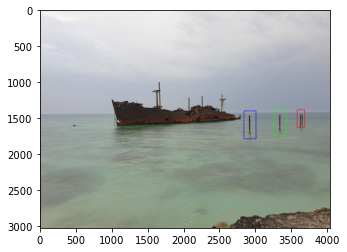

In [5]:
match_locations, sizes = find_matches(ship, patch, 2.9, 0.2, 0.5, 0.9, 0.1)

ship_cp = ship.copy()
cols = [(0, 0, 255), (0, 255, 0), (255, 0, 0), (255, 255, 0), (255, 0, 255), (0, 255, 255), (0, 0, 0)]
for c, loc, sz in zip(range(len(sizes)), match_locations, sizes):
    cv.rectangle(ship_cp, (loc[1], loc[0]),
                 (loc[1] + int(patch.shape[1] * sz), loc[0] + int(patch.shape[0] * sz)), cols[c % len(cols)], 5)

plt.imshow(cv.cvtColor(ship_cp, cv.COLOR_BGR2RGB))
plt.show()

<p style='direction:rtl; text-align: right'>
خروجی تابع match_template را به طور نمونه برای تمپلیت با سایز کامل می‌توانید ببینید.
</p>

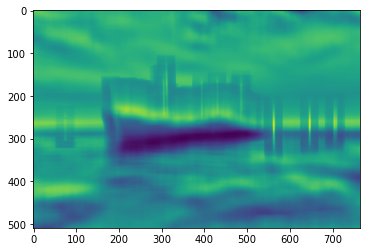

In [6]:
r = 0.2

r_patch = patch.copy()
r_patch = cv.resize(r_patch, (0, 0), r_patch, r, r, interpolation=cv.INTER_AREA)

r_ship = ship.copy()
r_ship = cv.resize(r_ship, (0, 0), r_ship, r, r, interpolation=cv.INTER_AREA)

mrs = match_template(r_ship, r_patch)
plt.imshow(mrs, cmap='viridis')
plt.show()
